# Espanish ULMFiT from scratch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *

In [2]:
# bs=48
# bs=24
bs=128

In [3]:
# torch.cuda.set_device(2)

In [3]:
data_path = Config.data_path(); data_path

PosixPath('/datafast/javiber/.fastai/data')

This will create a `viwiki` folder, containing a `viwiki` text file with the wikipedia contents. (For other languages, replace `vi` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [4]:
lang = 'es'
# lang = 'zh'

In [5]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']
path

PosixPath('/datafast/javiber/.fastai/data/eswiki')

## Espanish wikipedia model

### Download data

In [6]:
from nlputils import split_wiki,get_wiki

In [7]:
get_wiki(path,lang)

/datafast/javiber/.fastai/data/eswiki/eswiki already exists; not downloading


In [8]:
path.ls()

[PosixPath('/datafast/javiber/.fastai/data/eswiki/log'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/eswiki'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/models'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/eswiki-latest-pages-articles.xml'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/docs'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/wikiextractor'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/eswiki-latest-pages-articles.xml.bz2')]

In [9]:
!head -n4 {path}/{name}

<doc id="7" url="https://es.wikipedia.org/wiki?curid=7" title="Andorra">
Andorra

Andorra, oficialmente Principado de Andorra (), es un pequeño país soberano del suroeste de Europa. Constituido en Estado independiente, de derecho, democrático y social, cuya forma de gobierno es el coprincipado parlamentario. Su territorio está organizado en siete parroquias, con una población total de 78 282 habitantes. Su capital es Andorra la Vieja.


This function splits the single wikipedia file into a separate file per article. This is often easier to work with.

In [10]:
dest = split_wiki(path,lang)

/datafast/javiber/.fastai/data/eswiki/docs already exists; not splitting


In [12]:
dest.ls()[:5]

[PosixPath('/datafast/javiber/.fastai/data/eswiki/docs/Ion Luca Caragiale.txt'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/docs/Juan José Montes de Oca (médico).txt'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/docs/Pedro Camilo Franco.txt'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/docs/Distrito de Boquete.txt'),
 PosixPath('/datafast/javiber/.fastai/data/eswiki/docs/El Carbayón.txt')]

In [8]:
dest = Path('/datafast/javiber/.fastai/data/eswiki/docs')

In [ ]:
# Use this to convert Chinese traditional to simplified characters
# ls *.txt | parallel -I% opencc -i % -o ../zhsdocs/% -c t2s.json

### Create pretrained model

In [ ]:
data = (TextList.from_folder(dest)
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=8))

data.save(f'{lang}_databunch')
len(data.vocab.itos),len(data.train_ds)

In [9]:
data = load_data(path/'docs', f'{lang}_databunch', bs=bs)

### Sample

In [9]:
sample = (TextList.from_folder(dest)
            .filter_by_rand(0.1, seed=42)
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=16))

sample.save(f'{lang}_databunch_sample')
len(sample.vocab.itos),len(sample.train_ds)

(60000, 40530)

In [10]:
learn = language_model_learner(sample, AWD_LSTM, drop_mult=1, pretrained=False).to_fp16()

In [11]:
lr = 1e-2
lr *= bs/48  # Scale learning rate by batch size

In [12]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.878435,3.773497,0.321659,15:37
1,3.976288,3.852319,0.314584,15:40
2,3.996570,3.891692,0.310930,15:38
3,3.972999,3.841241,0.315664,15:38
4,3.921818,3.773446,0.319703,15:37
5,3.815292,3.674266,0.328842,15:39
6,3.726619,3.568360,0.337504,15:40
7,3.617370,3.455657,0.348079,15:40
8,3.547157,3.365438,0.356938,15:41
9,3.501343,3.336197,0.360241,15:42


In [15]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(f'{mdl_path/lm_fns[0]}_sample', with_opt=False)
learn.data.vocab.save(mdl_path/f'{lm_fns[1]}_sample.pkl')

### Full data

In [12]:
# learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()

In [10]:
mdl_path = path/'models'

learn = language_model_learner(data, AWD_LSTM, drop_mult=1, pretrained=False)
learn.load(f'{mdl_path/lm_fns[0]}_sample');
learn = learn.to_fp16()

In [11]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


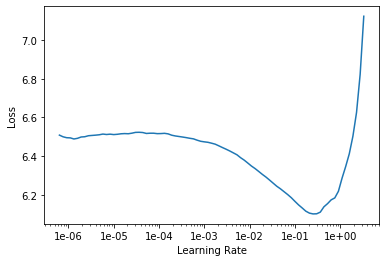

In [16]:
learn.recorder.plot()

In [13]:
lr = 1e-2
# lr *= bs/48  # Scale learning rate by batch size

In [14]:
from fastai.callbacks import SaveModelCallback
# learn.unfreeze()
learn.fit_one_cycle(
    10, lr, moms=(0.8,0.7),  
    callbacks=[
    SaveModelCallback(
            learn, every='epoch', monitor='accuracy', name='esLM')
        ])

epoch,train_loss,valid_loss,accuracy,time
0,3.492150,3.365658,0.357493,2:35:52
1,3.562045,3.456946,0.348355,2:35:52
2,3.605615,3.508311,0.343915,2:35:39
3,3.586841,3.492753,0.345466,2:35:42
4,3.554735,3.454936,0.348489,2:35:56
5,3.540326,3.403521,0.353333,2:35:46
6,3.504061,3.340822,0.359617,2:35:49
7,3.415219,3.263391,0.367790,2:36:16
8,3.369590,3.197876,0.375321,2:37:40


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Save the pretrained model and vocab:

In [75]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

## Vietnamese sentiment analysis

### Language model

- [Data](https://github.com/ngxbac/aivivn_phanloaisacthaibinhluan/tree/master/data)
- [Competition details](https://www.aivivn.com/contests/1)
- Top 3 f1 scores: 0.900, 0.897, 0.897

In [35]:
train_df = pd.read_csv(path/'train.csv')
train_df.loc[pd.isna(train_df.comment),'comment']='NA'
train_df.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm...,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1


In [36]:
test_df = pd.read_csv(path/'test.csv')
test_df.loc[pd.isna(test_df.comment),'comment']='NA'
test_df.head()

,id,comment
0,test_000000,Chưa dùng thử nên chưa biết
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua n...
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc...
3,test_000003,Vải đẹp.phom oki luôn.quá ưng
4,test_000004,Chuẩn hàng đóng gói đẹp


In [37]:
df = pd.concat([train_df,test_df], sort=False)

In [38]:
data_lm = (TextList.from_df(df, path, cols='comment')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [17]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [39]:
lr = 1e-3
lr *= bs/48

In [19]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.975080,4.138585,0.317773,00:07
1,4.408635,4.025489,0.326423,00:07


In [20]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.142114,3.928278,0.336230,00:09
1,4.010835,3.793583,0.349972,00:09
2,3.873617,3.694702,0.357240,00:09
3,3.761377,3.632186,0.364648,00:09
4,3.679017,3.595601,0.366964,00:09
5,3.614548,3.576386,0.369224,00:09
6,3.575895,3.567496,0.370285,00:09
7,3.560278,3.566525,0.370173,00:10


In [21]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

### Classifier

In [40]:
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols='comment')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class')

In [10]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

In [41]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [43]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

In [44]:
lr=2e-2
lr *= bs/48

In [45]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,_inner,time
0,0.338150,0.275298,0.899876,0.878430,00:02
1,0.302302,0.245949,0.902985,0.877226,00:02


In [46]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,_inner,time
0,0.321768,0.255457,0.899254,0.871367,00:02
1,0.305934,0.250888,0.894901,0.872021,00:02


In [47]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,_inner,time
0,0.300939,0.261080,0.893657,0.866201,00:03
1,0.263790,0.220207,0.906716,0.886115,00:03


In [48]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,_inner,time
0,0.282888,0.238203,0.905473,0.886483,00:04
1,0.248599,0.216489,0.918532,0.901550,00:04


In [49]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,_inner,time
0,0.201508,0.217176,0.911070,0.890084,00:05


In [50]:
learn_c.save(f'{lang}clas')

Competition top 3 f1 scores: 0.90, 0.89, 0.89. Winner used an ensemble of 4 models: TextCNN, VDCNN, HARNN, and SARNN.

## Ensemble

In [65]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas', purge=False);

In [69]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9111), tensor(0.8952))

In [67]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_bwd', purge=False);

In [70]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.9092), tensor(0.8957))

In [71]:
preds_avg = (preds+preds_b)/2

In [72]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.9154), tensor(0.9016))